# Tracking how often mice visit leaf/end nodes

In [1]:
# Imports
from __future__ import print_function
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys

module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [3]:
# List number of bouts for each animal
print('mouse  bouts')
to=0
max_bouts = 0
for nickname in AllNames:
    tf = LoadTraj(nickname+'-tf')
    print(nickname+'     ',len(tf.no))
    
    if len(tf.no) > max_bouts:
        max_bouts = len(tf.no)
        
    to+=len(tf.no)
print('Total  ',to)

mouse  bouts
B1      104
B2      166
B3      147
B4      238
C1      173
C3      339
C6      150
C7      135
C8      164
C9      127
B5      245
B6      223
B7      204
D3      245
D4      319
D5      180
D6      59
D7      150
D8      109
D9      102
Total   3579


In [4]:
# define cell numbers of end/leaf nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}

In [5]:
# Generating a 'visits' dictionary with data about target level nodes
def gen_visit_table(end_nodes):
    '''
    visits[nickname][bout][node]: tallies number of times an end node was visited 
                                  (a valid visit is when the mouse had not already been at the node in the previous frame)
    visits[nickname][bout][total]: tallies number of times all target nodes were visited in the specific bout
    '''
    
    visits = {}
    for nickname in AllNames:

        # Loading mouse trajectory
        tf = LoadTraj(nickname+'-tf')

        # Initializing end node visit dictionary
        visits[nickname] = {}

        for bout, node_array in enumerate(tf.no[2:]):
            visits[nickname][bout] = {}
            prior_node = 0

            for node in end_nodes:
                visits[nickname][bout][node] = 0

            for node,frame in node_array:           
                # checking if the node visited in the current frame is an end node
                if node in end_nodes and node != prior_node:
                    visits[nickname][bout][node] += 1

                # keeping track of the mostly recently visited node
                prior_node = node
                
            visits[nickname][bout]['total'] = np.sum(np.asarray(list(visits[nickname][bout].values())))
    return visits

## Select results for output

In [6]:
# Create a table to output based on 'visits' dictionary
def f(bout,lvl):
    
    boutID = bout - 1
    
    # Select list of nodes to track based on level
    end_nodes = lvl_dict[lvl]
    print('Node list: ', end_nodes)
    
    visits = gen_visit_table(end_nodes)

    # Initialize new end node visit dictionary for the selected bout
    visits_bout = {}
    for nickname in AllNames:
        visits_bout[nickname] = {}
        for node in end_nodes:
            try:
                visits_bout[nickname][node] = visits[nickname][boutID][node]
            except:
                visits_bout[nickname][node] = np.nan

    # Create a new dataframe
    df = pd.DataFrame(visits_bout)

    # Print the output
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    print('\nLevel %i nodes visited during bout %i' %(lvl, bout))
    
    return df

In [7]:
# Creating some summary statistics specific to the target level nodes
def gen_summary(lvl):
    '''
    summary[nickname]['None']: % of bouts where NO end nodes were visited
    summary[nickname]['Once']: % of bouts where there was at most ONE visit to any end node
    summary[nickname]['Multiple']: % of bouts where there was at least TWO visits to any end node
    '''

    # Select list of nodes to track based on level
    end_nodes = lvl_dict[lvl]
    print('Node list: ', end_nodes)
    
    visits = gen_visit_table(end_nodes)
    
    summary = {}
    summary_bouts = {}
    for nickname in AllNames:
        summary[nickname] = {}
        summary[nickname]['None'] = 0
        summary[nickname]['Once'] = 0
        summary[nickname]['Multiple'] = 0
        summary_bouts[nickname] = {}
        summary_bouts[nickname]['None'] = []
        summary_bouts[nickname]['Once'] = []
        summary_bouts[nickname]['Multiple'] = []
        total_bouts = len(visits[nickname].keys())

        # Calculating % of bouts where NO end nodes were visited
        no_end_nodes = 0
        for bout in visits[nickname].keys():
            total_visits = visits[nickname][bout]['total']

            if total_visits == 0:
                no_end_nodes += 1
                summary_bouts[nickname]['None'].extend([bout+1])

        summary[nickname]['None'] = np.round(no_end_nodes * 100 / total_bouts)

        # Calculating % of bouts where there was at most only ONE visit to any end node
        one_end_node = 0
        multiple_end_node = 0
        for bout in visits[nickname].keys():
            total_visits = np.sum(np.asarray(list(visits[nickname][bout].values())))

            if total_visits != 0:
                one_visit = True
                for node in visits[nickname][bout]:

                    # Checking if an end node has been visited multiple times
                    if visits[nickname][bout][node] > 1:
                        one_visit = False

                if one_visit:
                    one_end_node += 1
                    summary_bouts[nickname]['Once'].extend([bout+1])
                elif not one_visit:
                    multiple_end_node += 1
                    summary_bouts[nickname]['Multiple'].extend([bout+1])

                summary[nickname]['Once'] = np.round(one_end_node * 100 / total_bouts)
                summary[nickname]['Multiple'] = np.round(multiple_end_node * 100 / total_bouts)
                
    return visits, summary, summary_bouts

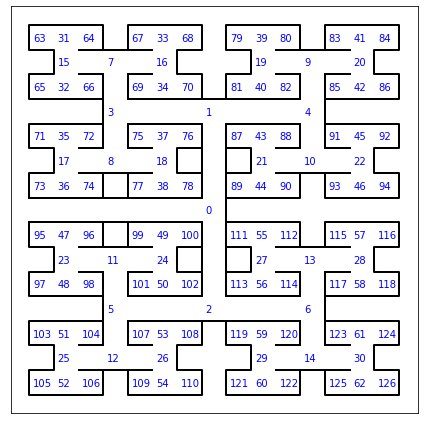

In [8]:
# Draw maze with node numbers
ma=NewMaze(6)
PlotMazeNodes(ma,figsize=6)

In [9]:
# Interative table to look at the number of times a specific level node was visited by each mouse for a specific bout
set_bout = 24
interact(f, bout=widgets.IntSlider(min=1, max=max_bouts, step=1, value=set_bout), 
         lvl = widgets.IntSlider(min=0, max=6, step=1, value=1));

interactive(children=(IntSlider(value=24, description='bout', max=339, min=1), IntSlider(value=1, description=…

In [31]:
# Creating a plot of the number of times target level nodes were visited per bout for each mouse
def gen_nodefreq_plot(visits, names):
    plt.figure(figsize=(20,10))
    for nickname in names:
        x_vals = np.arange(1,len(visits[nickname])+1)
        y_vals = [visits[nickname][bout]['total'] for bout in np.arange(len(visits[nickname]))]
        plt.plot(x_vals, y_vals, label=nickname)

    plt.xlabel('Bouts')
    plt.ylabel('Total target nodes visited')
    plt.title('Level %i nodes visit frequency per bout' %(lvl))
    plt.legend()

Node list:  [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]


 None: % of bouts where NO end nodes were visited
 Once: % of bouts where any end node was visited ONCE at most
 Multiple: % of bouts where any end node was visited MORE than ONCE


,B1,B2,B3,B4,C1,C3,C6,C7,C8,C9,B5,B6,B7,D3,D4,D5,D6,D7,D8,D9
None,20.0,4.0,45.0,17.0,6.0,13.0,12.0,11.0,2.0,2.0,33.0,43.0,48.0,47.0,45.0,10.0,100.0,31.0,12.0,18.0
Once,8.0,10.0,6.0,12.0,16.0,13.0,9.0,5.0,4.0,2.0,4.0,5.0,3.0,5.0,3.0,2.0,0.0,2.0,1.0,1.0
Multiple,73.0,85.0,50.0,71.0,78.0,74.0,78.0,83.0,94.0,95.0,63.0,52.0,49.0,49.0,53.0,89.0,0.0,67.0,87.0,81.0


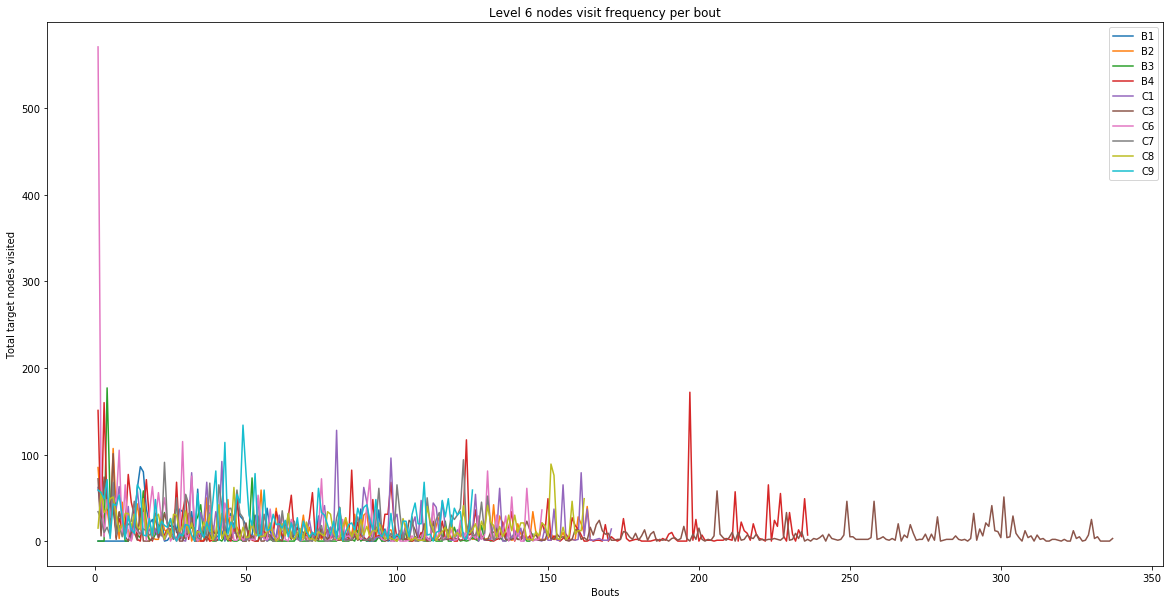

In [32]:
# Generate frequency of level node visits per bout plot
lvl = 6
names = RewNames  # AllNames, RewNames, UnrewNames
visits, summary, summary_bouts = gen_summary(lvl)
gen_nodefreq_plot(visits, names)

# Output summary statistics about the frequency of level node visits
df_summary = pd.DataFrame(summary)
print("\n\n None: % of bouts where NO end nodes were visited" 
       "\n Once: % of bouts where any end node was visited ONCE at most"
       "\n Multiple: % of bouts where any end node was visited MORE than ONCE")
df_summary